# Welcome!

This series of notebooks is focused on the creation, deployment, monitoring and management of a machine learning model for performing fraud detection. 

In this notebook we will be exploring the data, and training the machine learning model itself; in the form of an XGBoost classifier. 

This notebook and code within it is heavily inspired by the fantastic work of Arjun Joshua, you can find the original here: https://www.kaggle.com/arjunjoshua/predicting-fraud-in-financial-payment-services/notebook

-----------------------------------
First, we install and import the relevant packages which we will use throughout the exploration and training process. 

In [147]:
!pip install alibi==0.6.4
!pip install alibi_detect==0.8.1
!pip install dill
!pip install seaborn
!pip install seldon_deploy_sdk

In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score

from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

from seldon_deploy_sdk import Configuration, ApiClient, SeldonDeploymentsApi, ModelMetadataServiceApi, DriftDetectorApi, BatchJobsApi, BatchJobDefinition
from seldon_deploy_sdk.auth import OIDCAuthenticator

from alibi.explainers import AnchorTabular
from alibi_detect.cd import MMDDrift
from alibi_detect.utils.saving import save_detector, load_detector

import dill

# For repeatability
randomState = 5
np.random.seed(randomState)

/home/tom/miniconda3/envs/fraud-workshop/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
2022-04-13 15:03:26.016430: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-13 15:03:26.016459: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-13 15:03:28.935581: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-13 15:03:28.935654: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit:

We then download the dataset we will be using for the workshop, and load it into a Pandas DataFrame.

In [2]:
!gsutil cp gs://tom-seldon-examples/fraud-workshop/transaction-data.csv data/transaction-data.csv



Updates are available for some Cloud SDK components.  To install them,
please run:
  $ gcloud components update

Copying gs://tom-seldon-examples/fraud-workshop/transaction-data.csv...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

\ [1 files][470.7 MiB/470.7 MiB]   15.9 MiB/s                                   
Operation completed over 1 objects/470.7 MiB.                                    


In [3]:
df = pd.read_csv('data/transaction-data.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


It is worth taking a second to understand the features (columns of the table) within the dataset:
* `step`: This is a time series data set i.e. money transfers occur over time. 1 step represents 1 hour, with a total of 744 steps equivalent to 30 days. 
* `type`: The type of transaction: CASH-IN, CASH-OUT, DEBIT, PAYMENT, TRANSFER.
* `amount`: Amount of the transaction in local currency.
* `nameOrig`: Customer name who started the transaction.
* `oldBalanceOrig`: Initial balance before the transaction.
* `newBalanceOrig`: New balance after the transaction.
* `nameDest`: Customer name who is the recipient of the transaction.
* `oldBalanceDest`: Initial balance of the recipient before the transaction.
* `newBalanceDest`: New balance of the recipient after the transaction.
* `isFraud`: This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
* `isFlaggedFraud`: The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

It is worth noting that this is a synthetically generated dataset and so does not represent real world transactions, but is based upon the behaviour of a supplied real world dataset. You can read more about the data used [here](https://www.kaggle.com/ntnu-testimon/paysim1).

## Data Preparation

There are a number of data preparation steps which need to be performed prior to visualisation and model training. The first of which is to remove all transaction types apart from TRANSFER and CASH_OUT. These are the only transaction types where fraud occurs, and therefore the other types of transaction can be neglected. 

In [4]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

Next, we can remove a number of the feature columns which have no predictive power. These are the account name fields, as well as the `isFlaggedFraud` which has no clear relation to the other features. 

In [5]:
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

We then encode the transaction type categorical feature as a binary. Transactions types of TRANSFER will be 0, meanwhile CASH_OUT transactions will be 1. 

In [6]:
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

We now create our labels. This will simply be the `isFraud` field, and will be what our machine learning model attempts to predict based on the remaining transaction features. 

In [7]:
Y = X['isFraud']
del X['isFraud']

#### Working with Zero Balances

The data has several transactions with zero balances in the destination account both before and after a non-zero amount is transacted. The fraction of such Thetransactions, where zero likely denotes a missing value, is much larger in fraudulent (50%) compared to genuine transactions (0.06%).


Since the destination account balances being zero is a strong indicator of fraud we replace the values of oldBalanceDest and newBalanceDest with -1 where they are 0 originally, but have a non-zero transfer between them. 

In [8]:
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0), \
      ['oldBalanceDest', 'newBalanceDest']] = -1

The data also has several transactions with zero balances in the originating account both before and after a non-zero amount is transacted. In this case, the fraction of such transactions is much smaller in fraudulent (0.3%) compared to genuine transactions (47%). Once again, from similar reasoning as above, instead of imputing a numerical value we replace the value of 0 with -1.

In [9]:
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0), \
      ['oldBalanceOrig', 'newBalanceOrig']] = -1

Motivated by the possibility of zero-balances serving to differentiate between fraudulent and genuine transactions, we create 2 new features (columns) recording errors in the originating and destination accounts for each transaction. 

In [10]:
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

## Data Visualisation

Let's explore the data by generating a series of plots. 

First we create a function which allows us to generate strip plots readily.

In [11]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x = x, y = y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 14)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 14);
    return ax

Let's compare how genuine and fraudlent transacations are distributed over time. 

Text(0, 0.5, 'time [hour]')

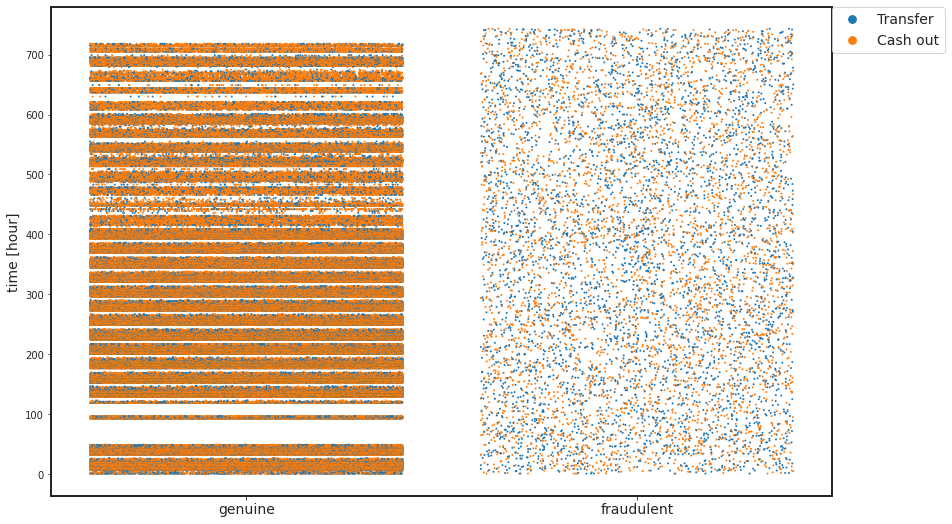

In [13]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 14)

We can see that genuine transactions have a more regular pattern, occuring at intervals with periods in between which do not see any genuine transactions occuring. These periods could represent weekends or holidays resulting in businesses being closed. Meanwhile, the fraudulent transactions are far more evenly distributed, with no discernible pattern. 

Furthermore, it's clear that the majority of genuine transcations are of type CASH OUT, whereas fraudulent transactions feature TRANSFER types far more prominently. 

-----

Next, we compare the transfer amount distributions for genuine and fraudulent transctions. 

Text(0, 0.5, 'amount')

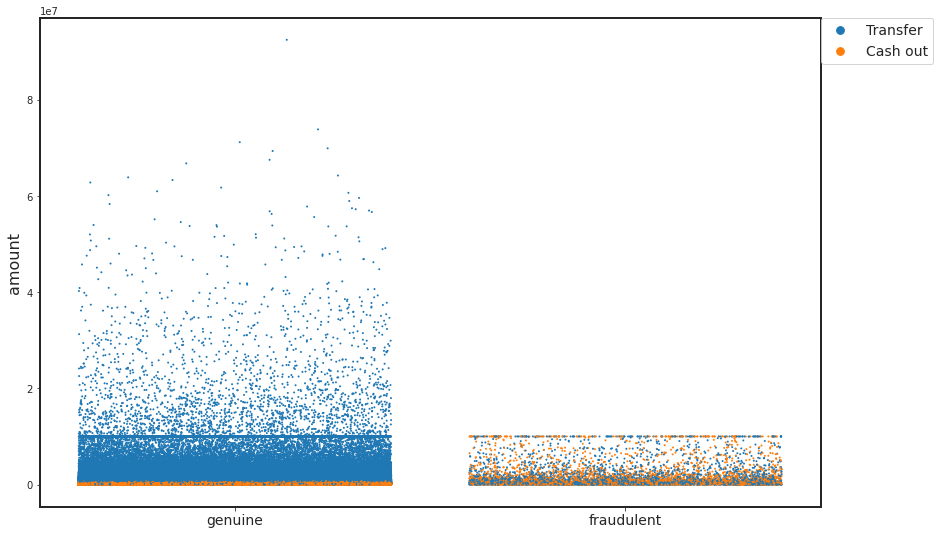

In [14]:
limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)

There is no clear pattern between genuine and fraudulent transactions by simply considering the amount. However, it appears there is a ceiling on the limit of a fraudulent transaction (10,000,000).

-----

Finally, we visualise the feature we created earlier `errorBalanceDest`, which is simply calculated by taking the previous balance of the destination account, plus the amount which was transferred minus new balance in the account. 

Remember, that many of the fraudulent transactions we observed had 0 account balance both before and after a non-zero sum of money was transferred. Therefore, the `errorBalanceDest` of these transactions will be a positive number equivalent to the value of the transfer.

Text(0, 0.5, 'errorBalanceDest')

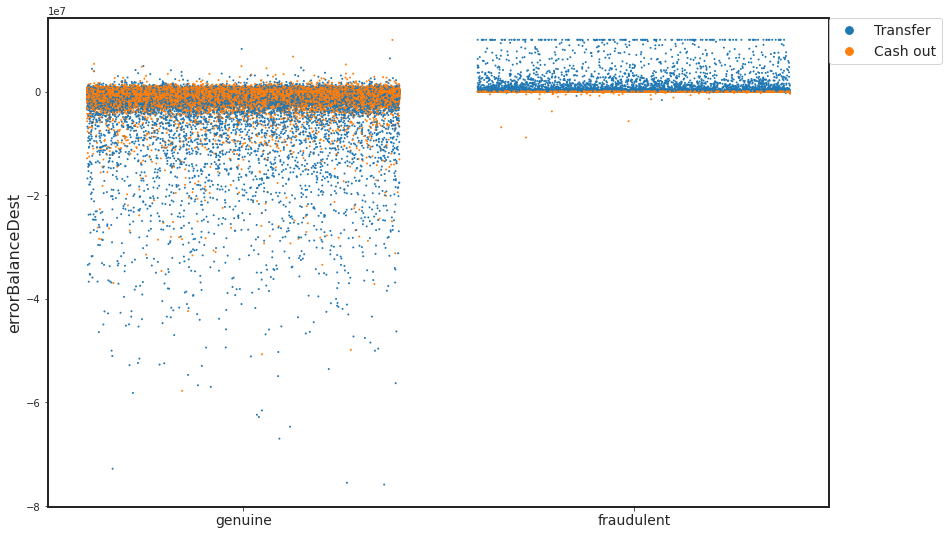

In [15]:
limit = len(X)
ax = plotStrip(Y[:limit], X.errorBalanceDest[:limit], X.type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('errorBalanceDest', size = 16)

From this figure we can see a clear distinction between genuine and fraudulent transactions with positive errorBalanceDest being recorded overwhelmingly more so for fraudulent transactions than genuine ones. 

# Model Training

Next we will train our predictor, to determine in an automated fashion whether a new transaction is fraudulent or not. 

We will be using an XGBoost classifier as it is naturally suited to handling such an imbalanced dataset, whereby only 0.3% of the transactions are fraudulent. 

In [16]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]

print('skew = {}'.format( len(Xfraud) / float(len(X)) ))

skew = 0.002964544224336551


We split our data into training and testing sets. 

In [17]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, random_state = randomState)

We also weight the positive class (fraudulent) more than the negative class (genuine) to help account for the overrepresentation of genuine transactions in the dataset. 

In [17]:
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())

We then train and score an XGBoost classifier. 

In [18]:
# Long computation in this cell (~1.8 minutes)

clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4, use_label_encoder=False)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, probabilities[:, 1])))

/home/tom/miniconda3/envs/fraud-workshop/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:56:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUPRC = 0.9984747968838775


We achieve a very impressive 0.99 AUPRC! Which means our classifier is accurately distinguishing between transactions. 

We can visualise the features which are most important to our new XGBoost classifier as shown below. 

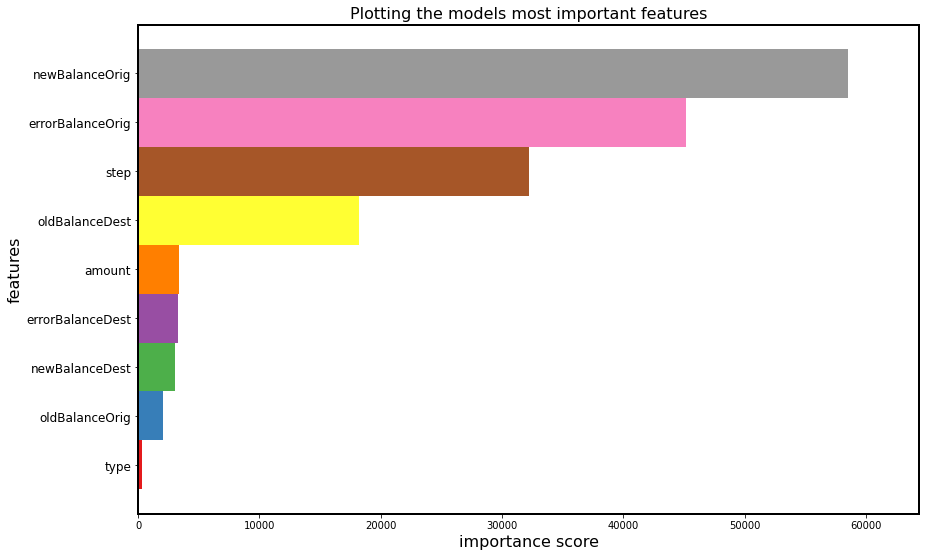

In [19]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Plotting the models most important features', size = 16);

We can now save our model, and upload it to an artefact store (in this case a Google storage bucket) ready for deployment.

We will be making use of the pre-packaged XGBoost model server, and therefore Seldon expects our classifier to be saved as `model.bst`. 

In [20]:
clf.save_model('model.bst')

We will now upload our saved model file to a Google storage bucket. 

### !!! IMPORTANT !!!
Make sure you fill in the WORKSHOP-NAME and YOUR-NAME to ensure you're not overwriting existing artefacts.

In [32]:
YOUR_NAME = "tom-farrand"
!gsutil cp model.bst gs://tom-seldon-examples/fraud-workshop/models/{YOUR_NAME}/model.bst

Copying file://model.bst [Content-Type=application/octet-stream]...
/ [1 files][ 64.2 KiB/ 64.2 KiB]                                                
Operation completed over 1 objects/64.2 KiB.                                     


# Deployment
We can now deploy our model to the dedicated Seldon Deploy cluster which we have configured for this workshop. To do so we will interact with the Seldon Deploy SDK and deploy our model using that. 

First, setting up the configuration and authentication required to access the cluster. Make sure to fill in the `SD_IP` variable to be the same as the cluster you are using. 

In [62]:
SD_IP = "35.204.38.10"

config = Configuration()
config.host = f"http://{SD_IP}/seldon-deploy/api/v1alpha1"
config.oidc_client_id = "sd-api"
config.oidc_server = f"http://{SD_IP}/auth/realms/deploy-realm"
config.oidc_client_secret = "sd-api-secret"
config.auth_method = "client_credentials"

def auth():
    auth = OIDCAuthenticator(config)
    config.id_token = auth.authenticate()
    api_client = ApiClient(configuration=config, authenticator=auth)
    return api_client

Now we have configured the IP correctly as well as setup our authentication function we can desrcibe the deployment we would like to create. 

You will need to fill in the `DEPLOYMENT_NAME`, `NAMESPACE`, and the `MODEL_LOCATION`, the rest of the deployment description has been templated for you. 

For the `MODEL_LOCATION` you do not need to specify the path all the way up to `model.bst` e.g. if you saved your classifier under `gs://tom-seldon-examples/my-workshop/tom/model.bst` your `MODEL_LOCATION` should be `gs://tom-seldon-examples/my-workshop/tom` and Seldon will automatically pick up the classifier artifact stored there. 

In [82]:
DEPLOYMENT_NAME = "fraud-detector-test"
NAMESPACE = "seldon-gitops"
MODEL_LOCATION = "gs://tom-seldon-examples/fraud-workshop/models/tom-farrand"

PREPACKAGED_SERVER = "XGBOOST_SERVER"

CPU_REQUESTS = "1"
MEMORY_REQUESTS = "1Gi"

CPU_LIMITS = "1"
MEMORY_LIMITS = "1Gi"

mldeployment = {
    "kind": "SeldonDeployment",
    "metadata": {
        "name": DEPLOYMENT_NAME,
        "namespace": NAMESPACE,
        "labels": {
            "fluentd": "true"
        }
    },
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "spec": {
        "name": DEPLOYMENT_NAME,
        "annotations": {
            "seldon.io/engine-seldon-log-messages-externally": "true"
        },
        "protocol": "seldon",
        "transport": "rest",
        "predictors": [
            {
                "componentSpecs": [
                    {
                        "spec": {
                            "containers": [
                                {
                                    "name": f"{DEPLOYMENT_NAME}-container",
                                    "resources": {
                                        "requests": {
                                            "cpu": CPU_REQUESTS,
                                            "memory": MEMORY_REQUESTS
                                        },
                                        "limits": {
                                            "cpu": CPU_LIMITS,
                                            "memory": MEMORY_LIMITS
                                        }
                                    }
                                }
                            ]
                        }
                    }
                ],
                "name": "default",
                "replicas": 1,
                "traffic": 100,
                "graph": {
                    "implementation": PREPACKAGED_SERVER,
                    "modelUri": MODEL_LOCATION,
                    "name": f"{DEPLOYMENT_NAME}-container",
                    "endpoint": {
                        "type": "REST"
                    },
                    "parameters": [],
                    "children": [],
                    "logger": {
                        "mode": "all"
                    }
                }
            }
        ]
    },
    "status": {}
}

We can now invoke the `SeldonDeploymentsApi` and create a new Seldon Deployment. 

Time for you to get your hands dirty. You will use the Seldon Deploy SDK to create a new Seldon deployment. You can find the reference documentation [here](https://github.com/SeldonIO/seldon-deploy-sdk/blob/master/python/README.md). 

In [83]:
deployment_api = SeldonDeploymentsApi(auth())
deployment_api.create_seldon_deployment(namespace=NAMESPACE, mldeployment=mldeployment)

{'api_version': 'machinelearning.seldon.io/v1alpha2',
 'kind': 'SeldonDeployment',
 'metadata': {'annotations': None,
              'cluster_name': None,
              'creation_timestamp': None,
              'deletion_grace_period_seconds': None,
              'deletion_timestamp': None,
              'finalizers': None,
              'generate_name': None,
              'generation': None,
              'labels': {'fluentd': 'true'},
              'managed_fields': None,
              'name': 'fraud-detector-test',
              'namespace': 'seldon-gitops',
              'owner_references': None,
              'resource_version': None,
              'self_link': None,
              'uid': None},
 'spec': {'annotations': {'seldon.io/engine-seldon-log-messages-externally': 'true'},
          'name': 'fraud-detector-test',
          'oauth_key': None,
          'oauth_secret': None,
          'predictors': [{'annotations': None,
                          'component_specs': [{'hpa_spec

We can now send requests to our model. As an example of a normal request:
```
{
    "data": {
        "names": ["step", "type", "amount", "oldBalanceOrig", "newBalanceOrig",
                  "oldBalanceDest", "newBalanceDest", "errorBalanceOrig", "errorBalanceDest"],
        "ndarray": [
            [205, 1, 63243.44, -1.00, -1.00, 1853683.32, 1916926.76, 63243.44, 0]
        ]
    }
}
```
And a fraudulent transaction too:

```
{
    "data": {
        "names": ["step", "type", "amount", "oldBalanceOrig", "newBalanceOrig",
                  "oldBalanceDest", "newBalanceDest", "errorBalanceOrig", "errorBalanceDest"],
        "ndarray": [
            [629, 1, 2433009.28, 2433009.28, 0.00, 0.00, 2433009.28, 0.00, 0.00]
        ]
    }
}
```

#  Prediction Schema

In [80]:
trainX.dtypes

step                  int64
type                  int64
amount              float64
oldBalanceOrig      float64
newBalanceOrig      float64
oldBalanceDest      float64
newBalanceDest      float64
errorBalanceOrig    float64
errorBalanceDest    float64
dtype: object

In [87]:
prediction_schema = {
    "requests": [
        {
            "name": "step",
            "type": "REAL",
            "data_type": "INT"
        },
        {
            "name": "type",
            "type": "REAL",
            "data_type": "INT"
        },
        {
            "name": "amount",
            "type": "REAL",
            "data_type": "FLOAT"
        },
        {
            "name": "oldBalanceOrig",
            "type": "REAL",
            "data_type": "FLOAT"
        },
        {
            "name": "newBalanceOrig",
            "type": "REAL",
            "data_type": "FLOAT"
        },
        {
            "name": "oldBalanceDest",
            "type": "REAL",
            "data_type": "FLOAT"
        },
        {
            "name": "newBalanceDest",
            "type": "REAL",
            "data_type": "FLOAT"
        },
        {
            "name": "errorBalanceOrig",
            "type": "REAL",
            "data_type": "FLOAT"
        },
        {
            "name": "errorBalanceDest",
            "type": "REAL",
            "data_type": "FLOAT"
        }
    ],
    "responses": [
        {
            "name": "Likelihood of Fraud",
            "type": "REAL",
            "data_type": "FLOAT"
        }
    ]
}

In [89]:
YOUR_NAME = "tom-farrand"

model_catalog_metadata = {
      "URI": MODEL_LOCATION,
      "name": "Fraud Detector",
      "version": "v1.0",
      "artifactType": "XGBOOST",
      "taskType": "fraud classification",
      "tags": {
        "auto_created": "true",
        "author": f"{YOUR_NAME}"
      },
      "metrics": {},
      "project": "default",
      "prediction_schema": prediction_schema
    }

metadata_api = ModelMetadataServiceApi(auth())
metadata_api.model_metadata_service_update_model_metadata(model_catalog_metadata)

{}

In [90]:
metadata_response = metadata_api.model_metadata_service_list_model_metadata(uri=MODEL_LOCATION)
metadata_response

{'models': [{'artifact_type': 'XGBOOST',
             'creation_time': datetime.datetime(2022, 4, 13, 9, 0, 46, 203678, tzinfo=tzutc()),
             'metrics': {},
             'name': 'Fraud Detector',
             'prediction_schema': {'requests': [{'category_map': {},
                                                 'data_type': 'INT',
                                                 'n_categories': '0',
                                                 'name': 'step',
                                                 'schema': [],
                                                 'shape': [],
                                                 'type': 'REAL'},
                                                {'category_map': {},
                                                 'data_type': 'INT',
                                                 'n_categories': '0',
                                                 'name': 'type',
                                                 'schema': 

# Drift Detection

In [23]:
# MMDDrift Detector 
cd = MMDDrift(trainX.iloc[:5000].to_numpy(), backend='tensorflow', p_val=.05)

In [24]:
trainX.shape

(2216327, 9)

In [25]:
testX.shape

(554082, 9)

In [26]:
preds = cd.predict(testX.iloc[100:200].to_numpy(), return_p_val=True, return_distance=True)
preds

{'data': {'is_drift': 0,
  'distance': -0.0014183521,
  'p_val': 0.67,
  'threshold': 0.05,
  'distance_threshold': 0.0069375634},
 'meta': {'name': 'MMDDriftTF',
  'detector_type': 'offline',
  'data_type': None,
  'version': '0.8.1',
  'backend': 'tensorflow'}}

# Batch Job

In [129]:
workflow = BatchJobDefinition(
    batch_data_type='data',
    batch_gateway_endpoint='fraud-detector-test-default.seldon-gitops.svc.cluster.local:8000',
    batch_gateway_type='seldon',
    batch_interval=0.0,
    batch_method='predict',
    batch_payload_type='ndarray',
    batch_retries='3',
    batch_size=0,
    batch_transport_protocol='rest',
    batch_workers='1',
    input_data='minio://batch/fraud-batch.txt',
    object_store_secret_name='minio-bucket',
    output_data='minio://batch/api-fraud-batch-results.txt',
    pvc_size='1Gi'
)

In [130]:
batch_api = BatchJobsApi(auth())
batch_api.create_seldon_deployment_batch_job(DEPLOYMENT_NAME, NAMESPACE, workflow)

{'workflow_name': 'fraud-detector-test-ngm7m',
 'workflow_uid': '2d52cfce-c386-4d01-8efe-6a5f0ca13418'}

In [116]:
batch_api.list_seldon_deployment_batch_jobs(DEPLOYMENT_NAME, NAMESPACE)

{'batch_jobs': [{'FinishedAt': '2022-04-13T11:13:24Z',
                 'StartedAt': '2022-04-13T11:12:05Z',
                 'workflowName': 'fraud-detector-test-nnvjz',
                 'workflowStatus': 'Succeeded',
                 'workflowUID': '592c4512-362f-4e7c-9044-838c9dcf72f7'}],
 'limit': 10,
 'page': 0,
 'pages_count': 1}

In [117]:
batch_api.get_deployment_batch_job(DEPLOYMENT_NAME, NAMESPACE, "fraud-detector-test-nnvjz")

{'definition': {'batch_data_type': 'data',
                'batch_gateway_endpoint': 'fraud-detector-test-default.seldon-gitops.svc.cluster.local:8000',
                'batch_gateway_type': 'seldon',
                'batch_interval': 0.0,
                'batch_method': 'predict',
                'batch_payload_type': 'ndarray',
                'batch_retries': '3',
                'batch_size': 0,
                'batch_transport_protocol': 'rest',
                'batch_workers': '1',
                'input_data': 'minio://batch/fraud-batch.txt',
                'object_store_secret_name': 'minio-bucket',
                'output_data': 'minio://batch/fraud-batch-results.txt',
                'pvc_size': '1Gi'},
 'description': {'finished_at': '2022-04-13T11:13:24Z',
                 'started_at': '2022-04-13T11:12:05Z',
                 'workflow_name': 'fraud-detector-test-nnvjz',
                 'workflow_status': 'Succeeded',
                 'workflow_uid': '592c4512-362f-4e7c-

# Explainer
Next, we shall train an explainer to glean deeper insights into the decisions being made by our model. 

We will make use of the Anchors algorithm, which has a [production grade implementation available](https://docs.seldon.io/projects/alibi/en/stable/methods/Anchors.html) using the Seldon Alibi Explain library. 

The first step will be to write a simple prediction function which the explainer can call in order to query our XGBoost model. 

In [65]:
def predict_fn(x):
    return clf.predict_proba(x)

We then initialise our Anchor explainer, using the AnchorTabular flavour provided by Alibi due to our data modality. 

The AnchorTabular class expects the prediction function which we defined above, as well as a list of the feature names. You can find a sample notebook in the Alibi docs [here](https://docs.seldon.io/projects/alibi/en/stable/examples/anchor_tabular_adult.html). 

In [66]:
columns = list(trainX.columns)
explainer = AnchorTabular(predict_fn, columns)

We now need to fit our explainer object around some data so that it can learn to generate explanations based upon said data. 

As our training set is highly imbalanced (only a tiny fraction of our datapoints are fraudulent transactions) we create a new balanced set which is 50/50 normal/fraud transactions. This helps us to generate descriptive and useful explanations for both fraudulent and normal transactions.*

In the code block below we generate the new balanced set, and convert it to a numpy array as this is the type which Alibi expects. 

\*It is possible to generate a working explainer based upon the original dataset, but the anchors it identifies are not specific when considering normal transactions. The empty anchor is only ever returned due to the skew in the dataset. 

In [67]:
balanced_set = pd.concat([Xfraud, XnonFraud.iloc[:len(Xfraud)]]).to_numpy()

We then fit our explainer to our balanced data set. 

In [68]:
explainer.fit(balanced_set, disc_perc=(25, 50, 75)) 

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': None, 'disc_perc': (25, 50, 75)},
  'version': '0.6.5'}
)

We can now test our explainer on the test set, and view the explanations it begins to generate. Feel free to change the value of `idx` to see how it impacts the explanation generated. 

In [69]:
idx = 10

testX_array = testX.to_numpy()

class_names = ["Normal", "Fraudulent"]
print('Prediction: ', class_names[explainer.predictor(testX_array[idx].reshape(1, -1))[0]])

explanation = explainer.explain(testX_array[idx], threshold=0.95)
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Prediction:  Normal
Anchor: errorBalanceOrig > 158355.32 AND amount > 101185.00
Precision: 1.00
Coverage: 0.25


Explicitly testing a fraudulent transaction. 

In [70]:
print('Prediction: ', class_names[explainer.predictor(testX.loc[6272989].to_numpy().reshape(1, -1))[0]])

explanation = explainer.explain(testX.loc[6272989].to_numpy(), threshold=0.95)
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Prediction:  Fraudulent
Anchor: errorBalanceOrig <= 0.00
Precision: 0.97
Coverage: 0.54


In [71]:
list(testX.loc[6272989].to_numpy())

[629.0, 1.0, 2433009.28, 2433009.28, 0.0, 0.0, 2433009.28, 0.0, 0.0]

We now save our explainer, and upload it to the GS bucket. Your explainer must be saved as explainer.dill as once again Seldon Deploy will look for this artefact within a top level directory.

NOTE: Dill is used to serialise the object instead of pickle as it offers a greater flexibilty in the object types which can be serialised.

In [72]:
explainer.save("fraud-explainer")

Remember to fill in the WORKSHOP_NAME and YOUR_NAME in the command below. 

The explainer object which is generated is typically around 500MB and so can take a while to upload. 

In [73]:
!gsutil cp -r fraud-explainer gs://tom-seldon-examples/fraud-workshop/models/{YOUR_NAME}/fraud-explainer

Copying file://fraud-explainer/explainer.dill [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file://fraud-explainer/meta.dill [Content-Type=application/octet-stream]...
\ [2 files][191.3 MiB/191.3 MiB]                                                
Operation completed over 2 objects/191.3 MiB.               

# Deployment

We can now deploy our explainer alongside our model. First we define the explainer configuration. 

In [74]:
EXPLAINER_TYPE = "AnchorTabular"
EXPLAINER_URI = "gs://tom-seldon-examples/fraud-workshop/models/tom-farrand/fraud-explainer"

explainer_spec = {
                    "type": EXPLAINER_TYPE,
                    "modelUri": EXPLAINER_URI,
                    "containerSpec": {
                        "name": "",
                        "resources": {}
                    }
                }

We can then insert this additional configuration into our original `mldeployment` specification which we defined earlier. 

In [75]:
mldeployment['spec']['predictors'][0]['explainer'] = explainer_spec
mldeployment

{'kind': 'SeldonDeployment',
 'metadata': {'name': 'fraud-detector',
  'namespace': 'seldon-gitops',
  'labels': {'fluentd': 'true'}},
 'apiVersion': 'machinelearning.seldon.io/v1alpha2',
 'spec': {'name': 'fraud-detector',
  'annotations': {'seldon.io/engine-seldon-log-messages-externally': 'true'},
  'protocol': 'seldon',
  'transport': 'rest',
  'predictors': [{'componentSpecs': [{'spec': {'containers': [{'name': 'fraud-detector-container',
         'resources': {'requests': {'cpu': '1', 'memory': '1Gi'},
          'limits': {'cpu': '1', 'memory': '1Gi'}}}]}}],
    'name': 'default',
    'replicas': 1,
    'traffic': 100,
    'graph': {'implementation': 'XGBOOST_SERVER',
     'modelUri': 'gs://tom-seldon-examples/fraud-workshop/models/tom-farrand',
     'name': 'fraud-detector-container',
     'endpoint': {'type': 'REST'},
     'parameters': [],
     'children': [],
     'logger': {'mode': 'all'}},
    'explainer': {'type': 'AnchorTabular',
     'modelUri': 'gs://tom-seldon-examples

We then deploy the explainer to our Seldon Deploy cluster!

In [76]:
deployment_api = SeldonDeploymentsApi(auth())
deployment_api.create_seldon_deployment(namespace=NAMESPACE, mldeployment=mldeployment)

{'api_version': 'machinelearning.seldon.io/v1alpha2',
 'kind': 'SeldonDeployment',
 'metadata': {'annotations': None,
              'cluster_name': None,
              'creation_timestamp': None,
              'deletion_grace_period_seconds': None,
              'deletion_timestamp': None,
              'finalizers': None,
              'generate_name': None,
              'generation': None,
              'labels': {'fluentd': 'true'},
              'managed_fields': None,
              'name': 'fraud-detector',
              'namespace': 'seldon-gitops',
              'owner_references': None,
              'resource_version': None,
              'self_link': None,
              'uid': None},
 'spec': {'annotations': {'seldon.io/engine-seldon-log-messages-externally': 'true'},
          'name': 'fraud-detector',
          'oauth_key': None,
          'oauth_secret': None,
          'predictors': [{'annotations': None,
                          'component_specs': [{'hpa_spec': None,
 

We can now use the same example requests as before to generate both a prediction and then a subsequent explanation. 

An example of a normal request:
```
{
    "data": {
        "names": ["step", "type", "amount", "oldBalanceOrig", "newBalanceOrig",
                  "oldBalanceDest", "newBalanceDest", "errorBalanceOrig", "errorBalanceDest"],
        "ndarray": [
            [205, 1, 63243.44, -1.00, -1.00, 1853683.32, 1916926.76, 63243.44, 0]
        ]
    }
}
```
A fraudulent transaction:

```
{
    "data": {
        "names": ["step", "type", "amount", "oldBalanceOrig", "newBalanceOrig",
                  "oldBalanceDest", "newBalanceDest", "errorBalanceOrig", "errorBalanceDest"],
        "ndarray": [
            [629.0, 1.0, 2433009.28, 2433009.28, 0.0, 0.0, 2433009.28, 0.0, 0.0]
        ]
    }
}
```

# Conclusion
We have successfully cleaned and explored our dataset. We then trained an XGBoost classifier to distinguish between fraudulent and normal transactions which we subsequently saved and uploaded to a cloud storage bucket. We then deployed our model using the Seldon Deploy SDK, and used it to classify both a normal and a fraudlent transaction.